# 机器学习与量化策略


https://blog.csdn.net/weixin_46277779/article/details/128442624

机器学习在量化投资策略中的应用

https://www.ainumeric.com/article/ml_finance.php

分层聚类

https://medium.com/@orenji.eirl/hierarchical-risk-parity-with-python-and-riskfolio-lib-c0e60b94252e

In [2]:
import sqlite3
import pandas as pd  
import talib
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
import numpy as np
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [3]:
# 读取全量数据
def read_hq():
    
    conn=sqlite3.connect(r'F:\BaiduNetdiskDownload\stock_2018_daily\stock_2018.db')
    #stock_daily=pd.read_sql("select * from stock_daily",con=conn)
    stock_daily=pd.read_sql("select * from stock_daily where 股票代码>'003000.SZ'",con=conn)

    stock_daily.columns=['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close', 'volume',
           '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
           '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
           '总市值(万元)', '流通市值(万元)']
    stock_daily["date"]=stock_daily["date"].astype("str").astype("datetime64[ns]")
    stock_daily.set_index("date",inplace=True,drop=False)
    stock_daily.index.names = ['date_index']
    stock_daily["openinterest"]=0
    return stock_daily

#从全量数据中抽取个别股票数据
def get_data_1(syboml,time,stock_d):
    stock=stock_d[stock_d["股票代码"]==syboml][["open","high","low","close","volume","openinterest"]]
    stock=pd.concat([stock,time],axis=1).fillna(method="bfill").fillna(method="ffill")
    #stock=pd.concat([stock,time],axis=1).fillna(-1)#对每只股票缺失的交易日进行补齐
    return stock[["open","high","low","close","volume","openinterest"]]


#定义单个交易日中的策略
class my_strategy_date_2(bt.Strategy):
    #全局设定交易策略的参数
    cash_value={}
    params = (
        ("sell_d",{}),("buy_d",{})  # 注意要有逗号！！
    )

    def __init__(self):
        # 初始化交易指令、买卖价格和手续费
        self.order = None

    #单个交易日中的策略：先比较当天是否在买入或者卖出的日期中，如果在就获取日期对应的股票列表进行买卖操作
    def next(self):
        # 检查是否持仓 
        #print(str(self.datetime.date(0)))
        self.cash_value.update({str(self.datetime.date(0)):self.broker.getvalue()})#记录持仓
        if str(self.datetime.date(0)) in self.params.sell_d.keys(): # 卖出目标股票
            s_list=self.params.sell_d[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0,data=i)
        if str(self.datetime.date(0)) in self.params.buy_d.keys(): # 买入目标股票
            s_list=self.params.buy_d[str(self.datetime.date(0))]
            for i in s_list:
                self.order_target_percent(target=0.9/len(s_list),data=i)
                

    # 下面两个函数log与notify_order都是为了在交易过程中输出交易记录和其他信息        
    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) # 拿现在的日期
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

#读入策略并在所有交易日执行
def huice_run_num(start,end,buy_date,sell_date,stock_daily_x,stock_list,strategy):

    #实例化一个交易程序
    cerebro = bt.Cerebro()

    #把所有涉及到的股票数据塞入交易程序
    time_jy=pd.Series(range(0,len(stock_daily_x.date.unique())),index=stock_daily_x.date.unique()).sort_index()#构建包含所有交易日的序列
    for i in stock_list:#逐个输入涉及到的所有股票数据
        stock=get_data_1(i,time_jy,stock_daily_x)
        data = bt.feeds.PandasData(dataname=stock,fromdate=start,todate=end)           
        cerebro.adddata(data,name=i) 
    
    #交易程序读入对应策略
    cerebro.addstrategy(strategy,sell_d=sell_date,buy_d=buy_date) 
    cerebro.broker.setcash(1000000) #定义初始金额
    cerebro.broker.setcommission(commission=0.002)#定义佣金


    #下面是数据交易完成后的相关评估参数
    print(start.date(),end.date())
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')#获得夏普率
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')#获得回撤
    results = cerebro.run()
    strat = results[0]
    print('最终资金: %.2f' % cerebro.broker.getvalue())
    print('夏普比率:', strat.analyzers.SharpeRatio.get_analysis())
    print('回撤指标:', strat.analyzers.DW.get_analysis())
    
    return strategy.cash_value #这是累计收益数据，如果需要自己作图可以用这个
    #return cerebro

In [4]:
stock_daily=read_hq()

In [6]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_list=["003002.SZ","003003.SZ","300001.SZ"]
buy_date={"2020-09-22":["003002.SZ","003003.SZ"]}
sell_date={"2023-02-02":["003002.SZ","003003.SZ"]}
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()

In [7]:
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2020-09-23, 买入003002.SZ, 成交量38006，成交价13.02
2020-09-23, 买入003003.SZ, 成交量27075，成交价18.28
2023-02-03, 卖出003002.SZ, 成交量-38006，成交价20.89
2023-02-03, 卖出003003.SZ, 成交量-27075，成交价12.09
最终资金: 1127333.06
夏普比率: OrderedDict([('sharperatio', 0.13881751787754126)])
回撤指标: AutoOrderedDict([('len', 58), ('drawdown', 8.112109741974255), ('moneydown', 99523.99033479998), ('max', AutoOrderedDict([('len', 455), ('drawdown', 47.60672029972452), ('moneydown', 563812.145)]))])


<Axes: >

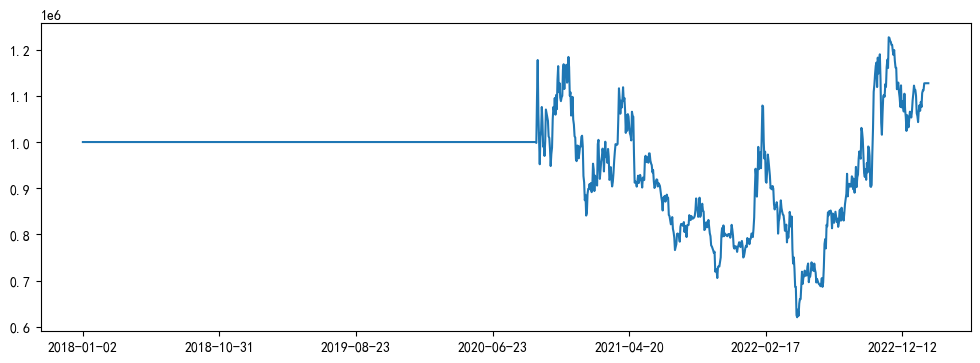

In [8]:
cash_value=pd.Series(result)
cash_value.plot(figsize=(12,4))

In [9]:
index_zh_a_hist_df = ak.index_zh_a_hist(symbol="000300", period="daily", start_date="20180222", end_date="20230210")
index_zh_a_hist_df.set_index("日期",inplace=True)
index_time=index_zh_a_hist_df["收盘"][start.date().isoformat():end.date().isoformat()]

<Axes: xlabel='日期'>

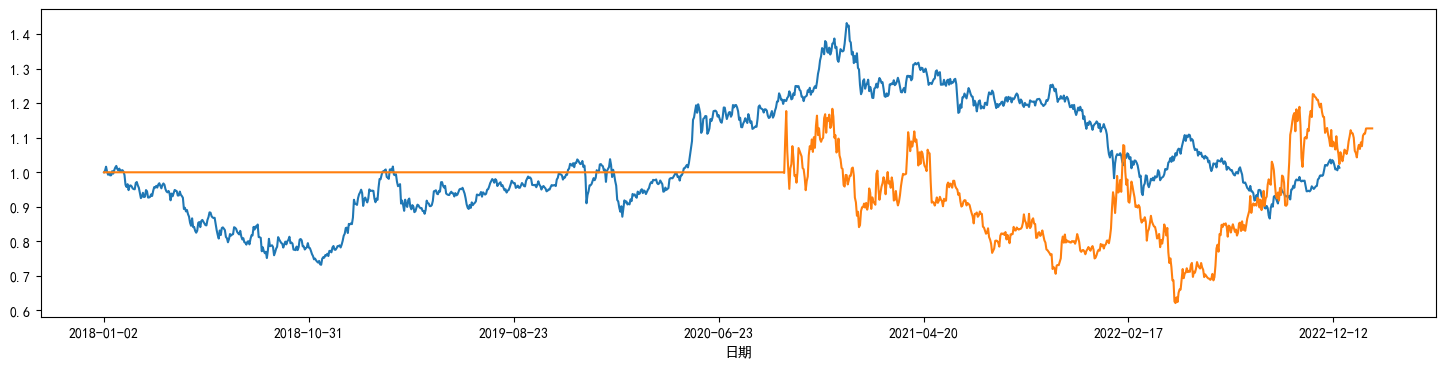

In [8]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

## 基于机器学习股票涨跌预测（二分类）

### 股票收益预测的特征工程


1. groupby与pct_change的联合使用 https://geek-docs.com/pandas/pandas-questions/579_pandas_pandas_groupby_multiple_columns_with_pct_change.html

2.重要的函数：pct_change apply(lambda x:1 if x>0 else 0) sample(frac=0.4) rank StandardScaler().fit_transform(xy_s_x)

In [14]:
stock_daily.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'openinterest'],
      dtype='object')

In [10]:
stock_daily["return_30"]=stock_daily.groupby('股票代码').close.pct_change(30)
stock_daily["return_30_shift30"]=stock_daily.groupby('股票代码').close.pct_change(30).shift(-30)
stock_daily["return_30_shift30_01"]=stock_daily["return_30_shift30"].apply(lambda x:1 if x>0 else 0)

In [12]:
stock_daily.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'openinterest', 'return_30',
       'return_30_shift30', 'return_30_shift30_01'],
      dtype='object')

In [16]:
stock_daily.isnull().sum()

index                        0
date                         0
股票代码                         0
股票简称                         0
open                         0
high                         0
low                          0
close                        0
volume                       0
成交额(千元)                      0
换手率(%)                       5
量比                        3109
市盈率(静态)                 133581
市盈率(TTM)                178112
市盈率(动态)                  15482
市净率                       5173
市销率                        241
市销率(TTM)                   679
股息率(%)                  187357
股息率(TTM)(%)             341124
总股本(万股)                      5
流通股本(万股)                     5
总市值(万元)                      5
流通市值(万元)                     5
openinterest                 0
return_30                38717
return_30_shift30        38717
return_30_shift30_01         0
dtype: int64

In [24]:
stock_daily[stock_daily["股票代码"]=="300588.SZ"][["return_30","return_30_shift30","return_30_shift30_rank"]].to_csv(r"stock_daily0")

### 基于分类算法的股票收益预测

* 数据标准化  StandardScaler (标准化/列归一化/无量纲化)

$x^{*}=(x-\bar{X})/s$

1. 作用于每一列

2. 处理方法如上公式，其中$\bar{X}$是样本的均值， s是样本的标准差

3. 常用的方法是z-score标准化，经过处理后的数据均值为0，标准差为1，标准化后的变量值围绕0上下波动，大于0说明高于平均水平，小于0说明低于平均水平

4. 该方法要求原始数据的分布可以近似为高斯分布，否标准化的效果会变得很糟糕

5. 数据以0为中心左右分布会带来很多便利。比如在去中心化的数据上做SVD分解等价于在原始数据上做PCA；机器学习中很多函数如Sigmoid、Tanh、Softmax等都以0为中心左右分布（不一定对称）.在分类、聚类算法中，需要使用距离来度量相似性的时候、或者使用PCA技术进行降维的时候


* 样本分割

* 模型训练

* 模型评价

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

#回归的评价 https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#分类的评价 https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [12]:
stock_daily[['市盈率(静态)','总市值(万元)']]=StandardScaler().fit_transform(stock_daily[['市盈率(静态)','总市值(万元)']].values)

In [13]:
stock_daily['总市值(万元)']

date_index
2020-10-13   -0.161409
2020-10-14   -0.148783
2020-10-15   -0.162398
2020-10-16   -0.165743
2020-10-19   -0.172987
                ...   
2023-02-13   -0.175340
2023-02-14   -0.174492
2023-02-15   -0.174800
2023-02-16   -0.177038
2023-02-17   -0.178581
Name: 总市值(万元), Length: 1132749, dtype: float64

In [69]:
xy=stock_daily[(stock_daily["date"]>=datetime(2018,1,2))&(stock_daily["date"]<=datetime(2022,1,2))][['市盈率(静态)','总市值(万元)',"return_30_shift30_01"]].dropna()
xy_s=xy.sample(frac=0.8)

In [70]:
xy_s_x=xy_s[['市盈率(静态)','总市值(万元)']].values
xy_s_y=xy_s["return_30_shift30_01"].values

In [71]:
x1,x2,y1,y2=train_test_split(xy_s_x,xy_s_y,test_size=0.7)#分割数据出训练集与测试集，0.7是两者行数的比例
clf = GradientBoostingClassifier()
clf = clf.fit(x1,y1)

In [72]:
confusion_matrix(y2,clf.predict(x2))

array([[157007,  51305],
       [129027,  64501]], dtype=int64)

In [73]:
accuracy_score(y2,clf.predict(x2))

0.5512343221182561

In [64]:
clf.feature_importances_

array([0.35944321, 0.64055679])

In [21]:
clf.predict(x2)

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [22]:
z1=clf.predict_proba(x2)
z1

array([[0.31868909, 0.68131091],
       [0.34792202, 0.65207798],
       [0.5741619 , 0.4258381 ],
       ...,
       [0.49323212, 0.50676788],
       [0.50771488, 0.49228512],
       [0.57153577, 0.42846423]])

In [23]:
pd.Series(z1[:,1])

0         0.681311
1         0.652078
2         0.425838
3         0.480360
4         0.480745
            ...   
251145    0.505222
251146    0.621127
251147    0.506768
251148    0.492285
251149    0.428464
Length: 251150, dtype: float64

## 基于分类算法的量化策略实现方法

In [24]:
time_i=stock_daily.date.sort_values().unique()

In [32]:
time_i[975]

Timestamp('2022-01-06 00:00:00')

In [74]:
time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(975,len(time_i),30):
    stock_chi=stock_daily[(stock_daily.date==time_i[i+1])&(stock_daily.open!=stock_daily.close)]["股票代码"].tolist()
    stock_oneday=stock_daily[(stock_daily.date==time_i[i])&stock_daily["股票代码"].isin(stock_chi)][["股票代码",'市盈率(静态)','总市值(万元)']].dropna()
    stock_oneday["scores"]=clf.predict_proba(stock_oneday[['市盈率(静态)','总市值(万元)']].values)[:,1]
    stock_list_z=stock_oneday.sort_values("scores").tail(5)["股票代码"].tolist()

    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

In [87]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2022-01-07, 买入300535.SZ, 成交量6491，成交价27.83
2022-01-07, 买入300059.SZ, 成交量94，成交价1909.92
2022-01-07, 买入300594.SZ, 成交量9290，成交价19.38
2022-01-07, 买入300210.SZ, 成交量7566，成交价24.57
2022-01-07, 买入300700.SZ, 成交量9404，成交价19.09
2022-02-25, 卖出300059.SZ, 成交量-94，成交价1483.14
2022-02-25, 卖出300210.SZ, 成交量-7566，成交价22.17
2022-02-25, 卖出300535.SZ, 成交量-6491，成交价28.52
2022-02-25, 卖出300594.SZ, 成交量-9290，成交价20.33
2022-02-25, 买入300999.SZ, 成交量3651，成交价52.67
2022-02-25, 买入300782.SZ, 成交量219，成交价881.39
2022-02-25, 买入300408.SZ, 成交量1294，成交价149.17
2022-02-25, 卖出300700.SZ, 成交量-3172，成交价30.87
2022-02-25, 买入300534.SZ, 成交量4336，成交价43.00
2022-04-12, 卖出300700.SZ, 成交量-6232，成交价21.50
2022-04-12, 卖出300782.SZ, 成交量-219，成交价605.34
2022-04-12, 卖出300408.SZ, 成交量-1294，成交价112.00
2022-04-12, 卖出300999.SZ, 成交量-3651，成交价47.85
2022-04-12, 卖出300534.SZ, 成交量-430，成交价39.55
2022-04-12, 买入300059.SZ, 成交量112，成交价1378.12
2022-04-12, 买入300665.SZ, 成交量8215，成交价18.82
2022-04-12, 买入300717.SZ, 成交量6846，成交价22.66
2022-04-12, 买入300594.SZ, 

<Axes: xlabel='日期'>

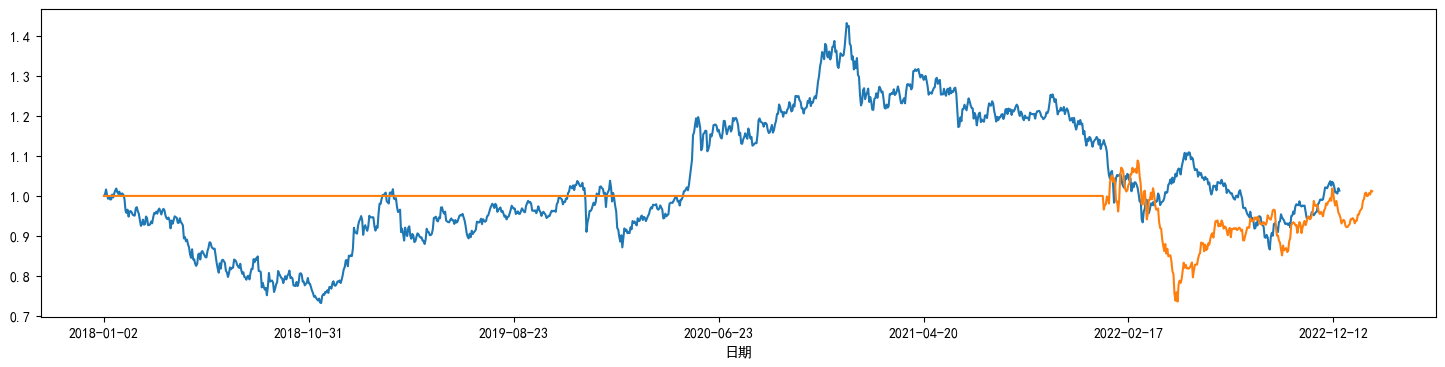

In [88]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

In [38]:
stock_oneday[['市盈率(静态)','总市值(万元)']].values

array([[-0.37441281, -0.20692302],
       [-0.38786929, -0.21596323],
       [-0.32270554, -0.22738782],
       ...,
       [-0.22219746, -0.04167169],
       [ 0.01286648, -0.14690523],
       [ 0.23222571, -0.03598058]])

In [42]:
stock_oneday["scores"]=clf.predict_proba(stock_oneday[['市盈率(静态)','总市值(万元)']].values)[:,1]

In [46]:
stock_oneday.sort_values("scores").tail(5)["股票代码"].tolist()

['300743.SZ', '300417.SZ', '300210.SZ', '300594.SZ', '300700.SZ']

In [42]:
# 多因子策略的模版

time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(0,len(time_i),30):
    stock_chi=stock_daily[(stock_daily.date==time_i[i+1])&(stock_daily.open!=stock_daily.close)]["股票代码"].tolist()
    stock_oneday=stock_daily[(stock_daily.date==time_i[i])&stock_daily["股票代码"].isin(stock_chi)]
    z1=stock_oneday.loc[:,'市盈率(静态)'].rank(ascending=False)+stock_oneday.loc[:,'总市值(万元)'].rank()
    stock_list_z=pd.concat([stock_oneday["股票代码"],z1],axis=1).sort_values(0)["股票代码"].head(5).tolist()

    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

In [118]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2022-01-07, 买入300836.SZ, 成交量5033，成交价35.99
2022-01-07, 买入300274.SZ, 成交量203，成交价875.14
2022-01-07, 买入300536.SZ, 成交量2673，成交价66.97
2022-01-07, 买入300122.SZ, 成交量366，成交价485.96
2022-01-07, 买入300981.SZ, 成交量2223，成交价81.44
2022-02-25, 卖出300836.SZ, 成交量-5033，成交价32.91
2022-02-25, 卖出300536.SZ, 成交量-2673，成交价55.24
2022-02-25, 卖出300122.SZ, 成交量-366，成交价494.75
2022-02-25, 卖出300981.SZ, 成交量-2223，成交价72.52
2022-02-25, 买入300782.SZ, 成交量189，成交价881.39
2022-02-25, 买入300554.SZ, 成交量5262，成交价31.83
2022-02-25, 买入300015.SZ, 成交量131，成交价1258.53
2022-02-25, 买入300274.SZ, 成交量6，成交价818.56
2022-02-25, 买入300124.SZ, 成交量105，成交价1571.69
2022-04-12, 卖出300274.SZ, 成交量-209，成交价660.83
2022-04-12, 卖出300124.SZ, 成交量-105，成交价1278.36
2022-04-12, 卖出300015.SZ, 成交量-131，成交价1162.87
2022-04-12, 卖出300782.SZ, 成交量-189，成交价605.34
2022-04-12, 卖出300554.SZ, 成交量-5262，成交价27.40
2022-04-12, 买入300479.SZ, 成交量2898，成交价47.21
2022-04-12, 买入300135.SZ, 成交量3961，成交价34.92
2022-04-12, 买入300454.SZ, 成交量1354，成交价102.15
2022-04-12, 买入301100.SZ, 

<Axes: xlabel='日期'>

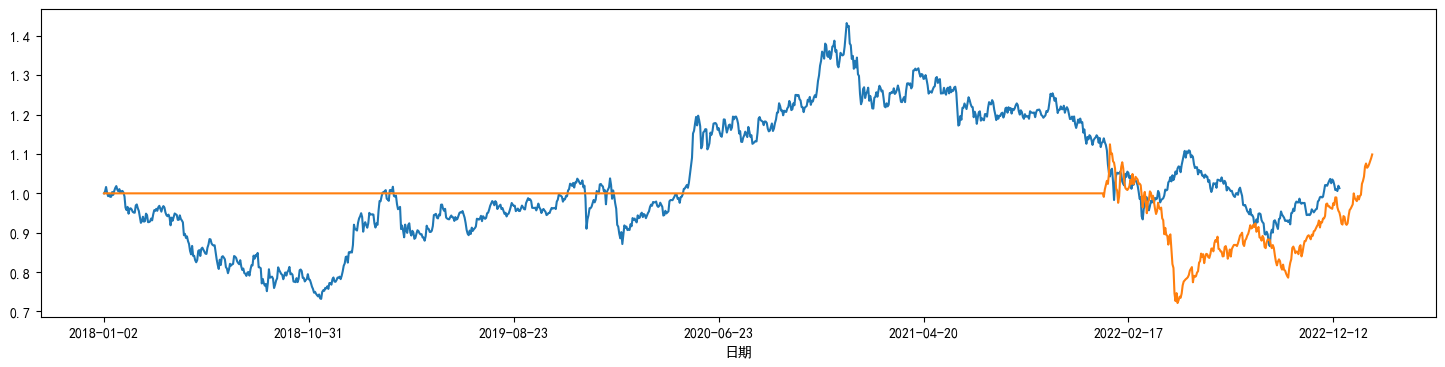

In [98]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

## 基于回归算法的预测股票收益及其策略实现

In [77]:
stock_daily.columns

Index(['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'openinterest', 'return_30',
       'return_30_shift30', 'return_30_shift30_01'],
      dtype='object')

In [78]:
xy=stock_daily[(stock_daily["date"]>=datetime(2018,1,2))&(stock_daily["date"]<=datetime(2022,1,2))][['市盈率(静态)','总市值(万元)','return_30_shift30']].dropna()
xy_s=xy.sample(frac=0.5)
xy_s_x=xy_s[['市盈率(静态)','总市值(万元)']].values
xy_s_y=xy_s["return_30_shift30"].values
x1,x2,y1,y2=train_test_split(xy_s_x,xy_s_y,test_size=0.7)#分割数据出训练集与测试集，0.7是两者行数的比例
clf = GradientBoostingRegressor()
clf = clf.fit(x1,y1)

In [79]:
r2_score(y2,clf.predict(x2))

0.011869912503168267

In [61]:
mean_absolute_error(y2,clf.predict(x2))

0.1310599815117247

In [86]:
time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(975,len(time_i),30):
    stock_chi=stock_daily[(stock_daily.date==time_i[i+1])&(stock_daily.open!=stock_daily.close)]["股票代码"].tolist()
    stock_oneday=stock_daily[(stock_daily.date==time_i[i])&stock_daily["股票代码"].isin(stock_chi)][["股票代码",'市盈率(静态)','总市值(万元)']].dropna()

    stock_oneday["scores"]=clf.predict(stock_oneday[['市盈率(静态)','总市值(万元)']].values)
    stock_list_z=stock_oneday.sort_values("scores").tail(5)["股票代码"].tolist()

    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

In [85]:
#clf.predict(stock_oneday[['市盈率(静态)','总市值(万元)']].values)

<Axes: xlabel='日期'>

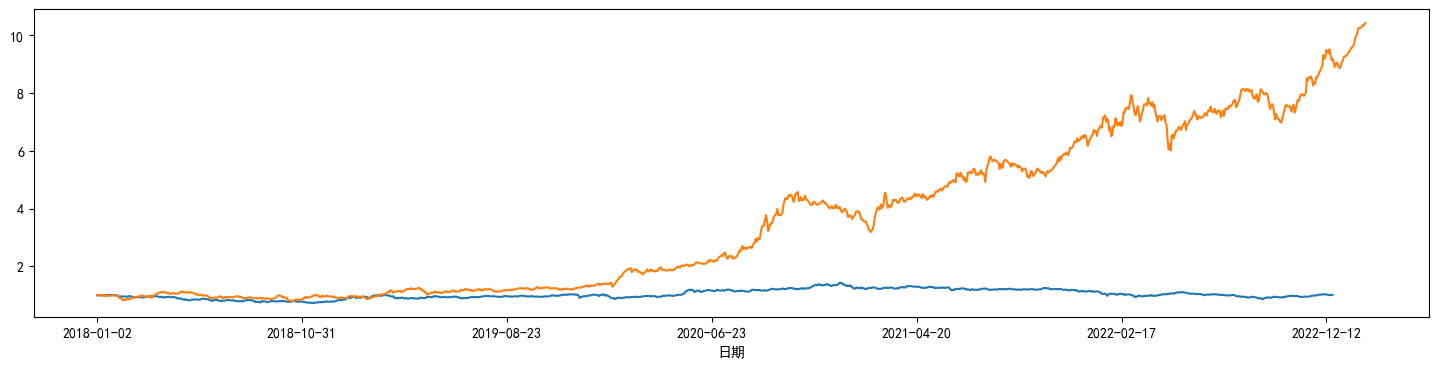

In [64]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

## 基于排名的特征处理在量化策略中的作用

* rank(pct=True)

In [72]:
stock_daily["return_30"]=stock_daily.groupby('股票代码').close.pct_change(30)
stock_daily["return_30_shift30"]=stock_daily.groupby('股票代码').close.pct_change(30).shift(-30)
stock_daily["return_30_shift30_01"]=stock_daily["return_30_shift30"].apply(lambda x:1 if x>0 else 0)

In [92]:
stock_daily["return_30_shift30_rank"]=stock_daily.groupby('date')["return_30_shift30"].rank(pct=True)
stock_daily["shiying_rank"]=stock_daily.groupby('date')['市盈率(静态)'].rank(pct=True)
stock_daily["shizhi_rank"]=stock_daily.groupby('date')['总市值(万元)'].rank(pct=True)

In [99]:
xy=stock_daily[(stock_daily["date"]>=datetime(2018,1,2))&(stock_daily["date"]<=datetime(2022,1,2))][["shiying_rank","shizhi_rank","return_30_shift30_rank"]].dropna()
xy_s=xy.sample(frac=0.99)
xy_s_x=xy_s[["shiying_rank","shizhi_rank"]].values
xy_s_y=xy_s["return_30_shift30_rank"].values
x1,x2,y1,y2=train_test_split(xy_s_x,xy_s_y,test_size=0.7)#分割数据出训练集与测试集，0.7是两者行数的比例
clf = GradientBoostingRegressor()
clf = clf.fit(x1,y1)

In [100]:
r2_score(y2,clf.predict(x2))

0.014352426281014963

In [101]:
mean_absolute_error(y2,clf.predict(x2))

0.2466569129779337

In [102]:
time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(975,len(time_i),30):
    stock_chi=stock_daily[(stock_daily.date==time_i[i+1])&(stock_daily.open!=stock_daily.close)]["股票代码"].tolist()
    stock_oneday=stock_daily[(stock_daily.date==time_i[i])&stock_daily["股票代码"].isin(stock_chi)][["股票代码","shiying_rank","shizhi_rank"]].dropna()

    stock_oneday["scores"]=clf.predict(stock_oneday[["shiying_rank","shizhi_rank"]].values)
    stock_list_z=stock_oneday.sort_values("scores").tail(5)["股票代码"].tolist()

    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

<Axes: xlabel='日期'>

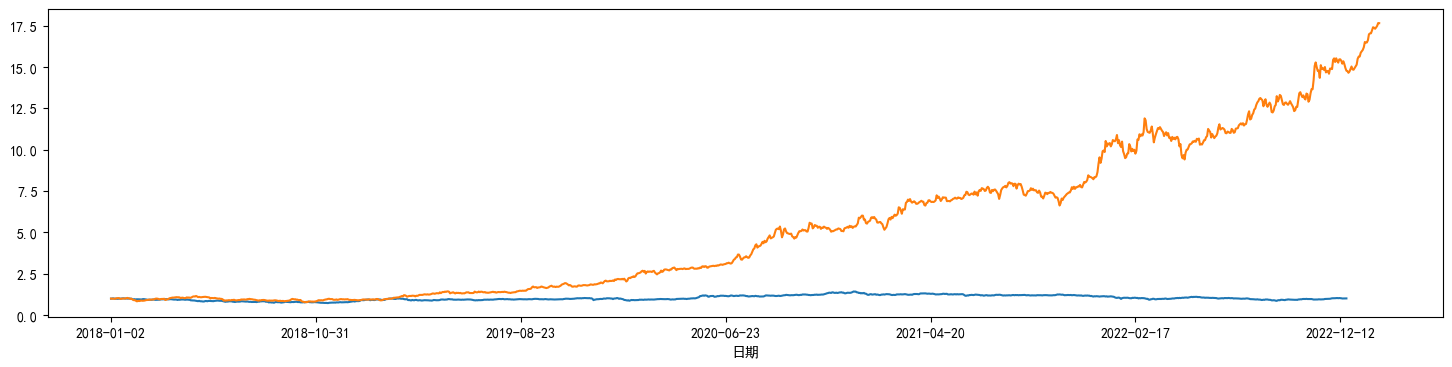

In [78]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

## 网格调参与交叉验证在机器学习量化策略中应用

* 网格调参：https://www.cnblogs.com/dalege/p/14175192.html
* GBDT 调参：https://blog.csdn.net/lizz2276/article/details/106484117/



`GradientBoostingRegressor`是Scikit-learn库中实现梯度提升回归算法的一个模型。在使用`cross_val_score`、`GridSearchCV`等模块进行模型评估或参数调优时，`scoring`参数用于指定评估模型性能的指标。对于回归问题，如`GradientBoostingRegressor`，`scoring`参数可以选取多种回归相关的评价指标，以下是一些常见的选择：

1. **均方误差 (Mean Squared Error, MSE)**: 这是最直接的损失函数，用于衡量预测值与真实值之间差异的平方和的平均值。在Scikit-learn中，可以通过字符串 `'neg_mean_squared_error'` 来指定，注意是负值，因为Scikit-learn中的优化目标默认是最大化分数。

2. **均方根误差 (Root Mean Squared Error, RMSE)**: 这是MSE的平方根，更直观地反映了预测误差的大小。Scikit-learn没有直接提供RMSE作为字符串参数，但你可以自定义评分函数或者使用 `'neg_root_mean_squared_error'` （如果版本支持的话）。

3. **平均绝对误差 (Mean Absolute Error, MAE)**: 衡量预测值与真实值之间的平均绝对差。用 `'neg_mean_absolute_error'` 表示。

4. **决定系数 R² (R-squared)**: 又称拟合优度，表示模型解释的变异性占总变异性的比例。在Scikit-learn中用 `'r2'` 表示。

5. **调整后的R² (Adjusted R²)**: 类似于R²，但考虑了模型中自变量的数量，对复杂模型有所惩罚，用以避免过拟合问题。Scikit-learn中没有直接的调整后R²字符串参数，可能需要手动计算。

6. **平均绝对百分比误差 (Mean Absolute Percentage Error, MAPE)**: 预测误差相对于真实值的百分比的平均值。Scikit-learn没有内置的MAPE作为字符串参数，需要自定义评分函数。

7. ** Median Absolute Error**: 中位数绝对误差，是所有观测值的绝对误差的中位数，用 `'median_absolute_error'` 表示。

当你在使用这些评分标准时，请确保理解它们的含义以及如何影响你的模型选择和评估过程。在Scikit-learn文档中，你可以找到更多关于[模型评估指标](https://scikit-learn.org/stable/modules/model_evaluation.html)的详细信息。

In [104]:
clf = GradientBoostingRegressor()

In [105]:
clf.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [108]:
list(range(80,101,5))

[80, 85, 90, 95, 100]

In [109]:
xy=stock_daily[(stock_daily["date"]>=datetime(2018,1,2))&(stock_daily["date"]<=datetime(2022,1,2))][["shiying_rank","shizhi_rank","return_30_shift30_rank"]].dropna()
xy_s=xy.sample(frac=0.4)
xy_s_x=xy_s[["shiying_rank","shizhi_rank"]].values
xy_s_y=xy_s["return_30_shift30_rank"].values
x1,x2,y1,y2=train_test_split(xy_s_x,xy_s_y,test_size=0.7)#分割数据出训练集与测试集，0.7是两者行数的比例

In [110]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(80,101,5),"learning_rate":[0.1,0.2,0.3]}
gs = GridSearchCV(GradientBoostingRegressor(),param_grid = param_test1, cv=5,n_jobs=-1, scoring='neg_mean_absolute_error')
gs.fit(x1,y1)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'n_estimators': range(80, 101, 5)},
             scoring='neg_mean_absolute_error')

In [111]:
gs.best_params_

{'learning_rate': 0.3, 'n_estimators': 100}

In [112]:
gs.best_score_

-0.2467511431398642

In [113]:
r2_score(y2,gs.predict(x2))

0.016080496202033667

In [114]:
mean_absolute_error(y2,gs.predict(x2))

0.24610930406376752

In [116]:
#gs.cv_results_

In [121]:
time_i=stock_daily.date.sort_values().unique()
top_num=5

stock_list=set([])
buy_date={}
sell_date={}
postion=set([])

for i in range(975,len(time_i),30):
    stock_chi=stock_daily[(stock_daily.date==time_i[i+1])&(stock_daily.open!=stock_daily.close)]["股票代码"].tolist()
    stock_oneday=stock_daily[(stock_daily.date==time_i[i])&stock_daily["股票代码"].isin(stock_chi)][["股票代码","shiying_rank","shizhi_rank"]].dropna()

    stock_oneday["scores"]=gs.predict(stock_oneday[["shiying_rank","shizhi_rank"]].values)
    stock_list_z=stock_oneday.sort_values("scores").tail(5)["股票代码"].tolist()

    stock_list=stock_list|set(stock_list_z)
    buy_date.update({str(time_i[i].date()):stock_list_z})
    sell_date.update({str(time_i[i].date()):list(postion-set(stock_list_z))})
    postion=set(stock_list_z)

In [122]:
start=datetime(2018,1,2)
end=datetime(2023,2,10)
stock_daily_part=stock_daily[(stock_daily["date"]>=start)&(stock_daily["date"]<=end)].copy()
result=huice_run_num(start,end,buy_date,sell_date,stock_daily_part,stock_list,my_strategy_date_2)

2018-01-02 2023-02-10
初始资金: 1000000.00
2022-01-07, 买入300836.SZ, 成交量5033，成交价35.99
2022-01-07, 买入300274.SZ, 成交量203，成交价875.14
2022-01-07, 买入300536.SZ, 成交量2673，成交价66.97
2022-01-07, 买入300122.SZ, 成交量366，成交价485.96
2022-01-07, 买入300981.SZ, 成交量2223，成交价81.44
2022-02-25, 卖出300836.SZ, 成交量-5033，成交价32.91
2022-02-25, 卖出300536.SZ, 成交量-2673，成交价55.24
2022-02-25, 卖出300122.SZ, 成交量-366，成交价494.75
2022-02-25, 卖出300981.SZ, 成交量-2223，成交价72.52
2022-02-25, 买入300782.SZ, 成交量189，成交价881.39
2022-02-25, 买入300554.SZ, 成交量5262，成交价31.83
2022-02-25, 买入300015.SZ, 成交量131，成交价1258.53
2022-02-25, 买入300274.SZ, 成交量6，成交价818.56
2022-02-25, 买入300124.SZ, 成交量105，成交价1571.69
2022-04-12, 卖出300274.SZ, 成交量-209，成交价660.83
2022-04-12, 卖出300124.SZ, 成交量-105，成交价1278.36
2022-04-12, 卖出300015.SZ, 成交量-131，成交价1162.87
2022-04-12, 卖出300782.SZ, 成交量-189，成交价605.34
2022-04-12, 卖出300554.SZ, 成交量-5262，成交价27.40
2022-04-12, 买入300479.SZ, 成交量2898，成交价47.21
2022-04-12, 买入300135.SZ, 成交量3961，成交价34.92
2022-04-12, 买入300454.SZ, 成交量1354，成交价102.15
2022-04-12, 买入301100.SZ, 

<Axes: xlabel='日期'>

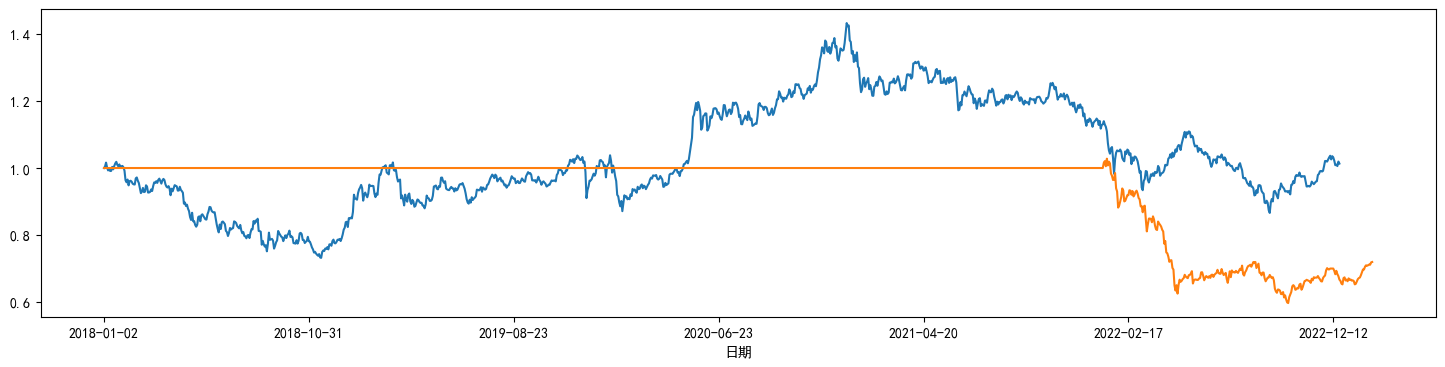

In [123]:
index_time_scale=index_time/index_time.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=pd.Series(result)/1000000
cash_value.plot()

automl 自动化机器学习

https://cloud.tencent.com/developer/article/2069069